# Graph validation

This notebook is split into several sections, demonstrating different graph validation concepts.

## Table of Contents
- [Setting up](#Setting-up)
- [Graph properties](#Graph-properties)
- [Circuity calcuations](#Circuity-calcuations)

## Setting up
The following packages are used in some or all of the sections that follow. 
Note that, in particular, `geopandas` can be tricky to install, see their [help page](https://geopandas.org/getting_started/install.html) for details.

As a "quick-start" way to use this notebook, you can install all required packages/dependencies for this notebook by navigating to this directory in a command prompt and running the following to create a conda environment named `gmns_env`. Note that this may not work for non-Windows machines.

```
conda env create -f environment.yml
```

In [1]:
import sqlite3
import pandas as pd
import geopandas as gpd # must be v0.9+ for GeoSeries.from_wkt()
import os, shutil
import networkx as nx # must be v2.5+ if using Python 3.9
import numpy as np
import time
import openmatrix as omx
import igraph as ig # pip install python-igraph


## Graph properties

The following code uses `networkx` to check the following:
- whether a node may have too many or too few neighbors based on its `node_type`
- whether the network is connected, and if not, a list of links not connected to the largest component
- whether there are any isolated nodes (nodes not connected to any link)

Note that this code considers the network to be undirected; future improvements could include testing connectedness on the directed graph.

In [2]:
# read in the Cambridge network, nodes and links
df_nodes = pd.read_csv('../Small_Network_Examples/Cambridge_v090/node.csv') # Replace with the path to your nodes file
df_links = pd.read_csv('../Small_Network_Examples/Cambridge_v090/link.csv') # Replace with the path to your links file

df_nodes = df_nodes.set_index('node_id', drop=False)
df_links = df_links.set_index('link_id', drop=False)

In [3]:
# creating the graph
#(note: multigraphs allow for multiple edges to be defined by the same pair of nodes, which we might need)
# it automatically creates a key to distinguish between edges with same pair of nodes
G = nx.from_pandas_edgelist(df_links, 'from_node_id', 'to_node_id', True, nx.MultiGraph)

# adding the node attributes
for i in G.nodes():
    G.nodes[i]['node_type'] = df_nodes.node_type[i]
    # add other attributes as needed


In [4]:
# flag on size of a node's neighborhood based on the `node_type` field
for i in sorted(G.nodes()): 
    if (len(G[i]) == 1 and G.nodes[i]['node_type'] != 'external'):
        print("Check node: ", i, " for connectivity; it appears to be external but is not labeled that way.")
    if (len(G[i]) == 2):
        print("Check node: ", i, " to see if it is necessary")
    if (len(G[i]) > 3 and G.nodes[i]['node_type'] in ['merge','diverge']): 
        print("Check node: ", i, " for extra connections; it is a merge/diverge with more than three connecting links")


Check node:  301  for connectivity; it appears to be external but is not labeled that way.
Check node:  302  for connectivity; it appears to be external but is not labeled that way.
Check node:  703  to see if it is necessary
Check node:  1701  for connectivity; it appears to be external but is not labeled that way.
Check node:  2101  to see if it is necessary
Check node:  2102  to see if it is necessary
Check node:  2501  to see if it is necessary
Check node:  2701  for connectivity; it appears to be external but is not labeled that way.
Check node:  2802  for connectivity; it appears to be external but is not labeled that way.
Check node:  12231  for connectivity; it appears to be external but is not labeled that way.


In [5]:
# checking connectivity
if nx.is_connected(G):
    print("The network is connected.")

else:
    # it may be the case that the pedestrian and automotive networks are each connected
    for val in [0,1]:
        val_to_txt = ["pedestrian (undirected)", "automotive (directed)"]
        H = nx.MultiGraph((a,b, key, attr) for a,b,key,attr in G.edges(data=True, keys=True) if bool(attr['directed']) == bool(val))
        if nx.is_connected(H):
            print("The {} network is connected".format(val_to_txt[val]))
            continue
        # list of nodes in the largest component of the graph
        largest_cc = max(nx.connected_components(H), key=len)
        for a,b,key,link in H.edges(data='link_id', keys=True):
            if a not in largest_cc:
                # (only need to test one node since a in component & ab an edge implies b in component)
                print("The link with ID ", link, " is not connected to the rest of the {} network.".format(val_to_txt[val]))
                # These links will need to be cleaned up before using the network in a model.


The pedestrian (undirected) network is connected
The automotive (directed) network is connected


In [6]:
# check isolates
if list(nx.isolates(G)):
    for v in nx.isolates(G):
        print("The node with ID " + str(v) + " is isolated (has no edges)")
        # These nodes should be reviewed to see if they can be deleted
else:
    print("No isolated vertices.")
    

No isolated vertices.


## Circuity calcuations

Given a network that meets the following constraints:
- The `node` table contains travel analysis zone centroids which are indicated by the value `"centroid"` in the `node_type` field. Links exist in the link table to connect these centroids to the road network.
- Geometries are stored in the `geometry` or `x_coord` and `y_coord` fields rather than a separate `geometry` table. The coordinate system used is WGS84 lat-long.

The [generating matrices](#generating-matrices) sub-section calculates straight-line distances, shortest paths (distance-based) along the network, and the circuity (the ratio between the sp and sl distances) between each pair of zone centroids. These results are then saved in an [OMX](https://github.com/osPlanning/omx) file for analysis. The current process could be improved by adding weight to the centroid connectors to avoid routing via them as intermediate links in a shortest path.

The [using the results](#using-the-results) sub-section demonstrates investigating suspect circuity values (e.g., outside of [1,2]); including mapping specific shortest paths on the network. Further analysis could include comparing the shortest-path matrix to skims generated by a routing package such as [AequilibraE](https://github.com/aequilibrae/aequilibrae).

This section of the notebook uses a [GMNS network of the Lima area](), to demonstrate capabilities on a moderately-sized network. The network contains 493 zones, 2232 nodes, and 145179 links.

Some values in this script are hard-coded to reflect that link lengths are reported in miles in this dataset. This could be generalized in future iterations.

In [7]:
df_links = pd.read_csv("../Small_Network_Examples/Lima/GMNS/link.csv")
df_nodes = pd.read_csv("../Small_Network_Examples/Lima/GMNS/node.csv")

df_nodes = df_nodes.set_index('node_id', drop=False)
df_links = df_links.set_index('link_id', drop=False)

# get centroids
df_taz = df_nodes[df_nodes["node_id"] < 99999] # todo add "centroid" to node_type for these in dataset
tazdictrow = {}
for index in df_taz.index:
    #DEBUG print(index, df_node['node_id'][index], df_node['node_type'][index])
    tazdictrow[df_taz['node_id'][index]]=index
taz_list = list(tazdictrow.keys())
matrix_size = len(tazdictrow)   #Matches the number of nodes flagged as centroids
print(matrix_size)   #DEBUG
highest_centroid_node_number = max(tazdictrow, key=tazdictrow.get)  #for future use
print(highest_centroid_node_number)  #DEBUG


449
493


### generating matrices


In [8]:
# calculate straight-line (sl) distances
gdf_taz = gpd.GeoDataFrame(df_taz, geometry=gpd.points_from_xy(df_taz["x_coord"], df_taz["y_coord"]), crs=3735) # 3735=OH State Plane South (Feet)
# gdf_taz = gdf_taz.to_crs(2240) # Georgia State Plane West (feet), pick an appropriate CRS for your region

# using GeoSeries can calculate all to-nodes from a single from-node at once
def sl_dists_mi(a):
    pt_a = gdf_taz.loc[a].geometry
    bs = gdf_taz.geometry
    return bs.distance(pt_a) / 5280 # since we picked a CRS in feet

# start_time = time.time()
df = pd.DataFrame(columns=taz_list)
for row in taz_list:
    dfrow = sl_dists_mi(row)
    df = df.append(dfrow, ignore_index=True)
#    if row % 1000 == 0: 
#        print(row)
# print(time.time() - start_time)
# for Atlanta, took about 10 minutes

In [9]:
# write sl distances to matrix
outfile = os.path.join(os.getcwd() ,'circuity_lima.omx')

f_output = omx.open_file(outfile,'w')
f_output.create_mapping('taz',taz_list)
sl_array = df.to_numpy()
f_output['sl_matrix'] = sl_array
#f_output.close()


In [10]:
# optional step, recalculate link lengths for shortest path
# (for sample dataset, the df_links length field matches closely with the output but some zero values present)
df_geom = pd.read_csv("../Small_Network_Examples/Lima/GMNS/geometry.csv")#.set_index("geometry_id", drop=False))
df_links_join = df_links.merge(df_geom, on="geometry_id")
#df_links_join

gdf_links = gpd.GeoDataFrame(df_links_join, geometry = gpd.GeoSeries.from_wkt(df_links_join['geometry_y'], crs=3735))
#gdf_links_joined = gdf_links.merge(gdf_links, gdf_geom, on="geometry_id")
#gdf_links = gdf_links.to_crs(2240)
gdf_links["len_new"] = gdf_links["geometry"].length / 5280


In [11]:
# we use igraph this time for graph analysis (it's faster)
# for igraph: need from and to nodes to be first two cols
# just pulling what we need for sp
# from and to must be first two cols of df_ig_e
df_ig_e = gdf_links[["from_node_id", "to_node_id", "link_id", "length", "len_new"]] 
df_ig_n = df_nodes[["node_id", "name", "x_coord", "y_coord"]]

# igraph node IDs are autogenerated, can't choose them, but if they have a name attribute we can use those instead
# use strs to avoid confusion with the auto-assigned int ids
df_ig_n = df_ig_n.assign(name = df_ig_n["node_id"].astype(str))
g = ig.Graph.DataFrame(df_ig_e, directed=True, vertices=df_ig_n)


In [12]:
# generate shortest paths

start_time = time.time()
sp_list = g.shortest_paths(taz_list,taz_list,weights="len_new") # now using recalculated lengths
print(time.time() - start_time)
# 82 seconds for Atlanta


0.10317707061767578


In [13]:
# write sp matrix to omx
sp_array = np.array(sp_list)
#outfile = os.path.join(os.getcwd() ,'circuity.omx')

#f_output = omx.open_file(outfile,'a')
f_output['sp_matrix'] = sp_array
#f_output.close()


In [14]:
circuity = sp_array/sl_array # sl distance for a node to itself is 0, results in nan
circuity = np.nan_to_num(circuity, nan=1.0)

#outfile = os.path.join(os.getcwd() ,'circuity.omx')
#f_output = omx.open_file(outfile,'a')
f_output['circuity'] = circuity
f_output.close()

C:\Users\IAN~1.BER\AppData\Local\Temp/ipykernel_14116/1922083206.py:1: RuntimeWarning: invalid value encountered in true_divide
  circuity = sp_array/sl_array # sl distance for a node to itself is 0, results in nan


### using the results


In [11]:
# read existing files (can skip if you generated them in the above section)
infile = os.path.join(os.getcwd() ,'circuity.omx')
f_input = omx.open_file(infile,'r')
circuity = np.array(f_input['circuity'])
sp_array = np.array(f_input['sp_matrix'])
sl_array = np.array(f_input['sl_matrix'])
f_input.close()

In [15]:
# checking summmary of results,
# first where circuity is less than 1
print(len(np.argwhere(circuity<1))/(matrix_size**2)) # check fraction of matrix with errors
print(np.argwhere(circuity<1)) # 693,694 and vv
circuity[np.where(circuity<1)] # 0.9999986, close enough

0.310826831216115
[[  0   1]
 [  0   3]
 [  0   6]
 ...
 [448 445]
 [448 446]
 [448 447]]


array([0.78114132, 0.35699318, 0.99854605, ..., 0.02183529, 0.00967895,
       0.00440315])

In [16]:
# now where circuity > 2
print(len(np.argwhere(circuity>2))/(matrix_size**2)) # check fraction of matrix with errors
np.argwhere(circuity>2)

0.07942420920531149


array([[  0,   5],
       [  0,   7],
       [  0,  14],
       ...,
       [448, 373],
       [448, 374],
       [448, 375]], dtype=int64)

In [17]:
# investigate the max circuity, does it make sense?
print(np.argwhere(circuity == np.max(circuity)))
print(circuity[np.where(circuity == np.max(circuity))])


[[448 317]]
[124.40555701]


In [20]:
# need the graph and gdf to have been generated for this step

from_node_id = str(taz_list[448])
to_node_id = str(taz_list[317])

sp_edge_ids = g.get_shortest_paths(from_node_id,to_node_id,weights="len_new",output="epath")[0]
sp_link_ids = g.es[sp_edge_ids].get_attribute_values("link_id")
sp_links = gdf_links.loc[sp_link_ids]
sp_links.plot()

KeyError: "None of [Index(['493 104307', '104307 104310', '104310 318'], dtype='object')] are in the [index]"

<AxesSubplot:>

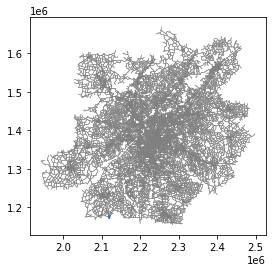

In [18]:
base = gdf_links.plot(lw=0.5, color="grey")
sp_links.plot(ax=base)
# hard to see but it's at the very edge of the network, which makes sense

In [19]:
# can do this for all paths above a certain circuity

df_long = pd.DataFrame(np.argwhere(circuity>5), columns=['fr', 'to'])
start_time = time.time()
all_links_in_long_paths = df_long.apply(lambda x: g.es[g.get_shortest_paths(x.fr, x.to, weights="len_new", output="epath")[0]].get_attribute_values("link_id"), axis=1)
print(time.time() - start_time)

all_list = [linkid for row in all_links_in_long_paths for linkid in row]
long_path_subset = gdf_links.loc[set(all_list)]

2.2875399589538574


<AxesSubplot:>

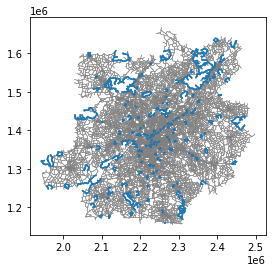

In [20]:
base = gdf_links.plot(lw=0.5, color="grey")
long_path_subset.plot(ax=base)

In [ ]:
'''
#below this line was a first attempt at shortest paths, using networkx
#which is slower than igraph, see https://graph-tool.skewed.de/performance

G = nx.from_pandas_edgelist(df_links, 'from_node_id', 'to_node_id', True, nx.MultiDiGraph)

for i in G.nodes():
    try:
        G.nodes[i]['x_coord'] = df_nodes.x_coord[i]
        G.nodes[i]['y_coord'] = df_nodes.y_coord[i]
        G.nodes[i]['pos'] = (G.nodes[i]['x_coord'],G.nodes[i]['y_coord']) # for drawing
        G.nodes[i]['node_type'] = df_nodes.node_type[i]  # could be used in future to filter out "fatal" issues
                                                    # e.g. path exists to an external node that only has inbound travel lanes
    except:
        print(i," not on node list")
        
#%%
def sp_dists_mi(a):
    taz_series = pd.Series(taz_list)
    return taz_series.apply(lambda x: nx.shortest_path_length(G,a,x, weight= "length"))

# try just one row
start_time = time.time()
row = sp_dists_mi(1)
print(time.time() - start_time)
# took 15min for one row 
'''